# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [2]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [154]:
# your code here
# Take a peek at your training set
data_train.head()

# Create the x and y train and test 
x_train_unscaled = data_train.drop('Cancer_type', axis=1)
x_test_unscaled = data_test.drop('Cancer_type', axis=1)

y_train = data_train['Cancer_type']
y_test = data_test['Cancer_type']

# Normalize each predictor to vary between 0 and 1
from sklearn.preprocessing import StandardScaler

scale_transformer = StandardScaler(copy=True).fit(x_train_unscaled)
x_train_scaled = scale_transformer.transform(x_train_unscaled)
x_test_scaled = scale_transformer.transform(x_test_unscaled)

# Convert returned numpy array to dataframe
x_train = pd.DataFrame(x_train_scaled, index=x_train_unscaled.index, columns=x_train_unscaled.columns)
x_test = pd.DataFrame(x_test_scaled, index=x_test_unscaled.index, columns=x_test_unscaled.columns)

x_train.shape

(40, 7129)

**1.3:** Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


<HR>
** Yes, this is definitely a problem. When there are more variables than data points, the problem may not have a unique solution unless it's further constrained. That is, there may be multiple (perhaps infinitely many) solutions that fit the data equally well.<BR><BR>Such a model would certainly overfit because it's 'too flexible' for the amount of training data. As model flexibility increases (e.g. more variables in a regression model) and the amount of training data shrinks, it becomes increasingly likely that the model will be able to achieve a low error by fitting random fluctuations in the training data that don't represent the true, underlying distribution. <BR><BR>Performance will therefore be poor when the model is run on future data drawn from the same distribution.**
<HR>

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

In [116]:
cancer_ALL = x_train[y_train==0]
cancer_AML = x_train[y_train==1]

(15, 7129)

Text(0.1,0.5,'Counts')

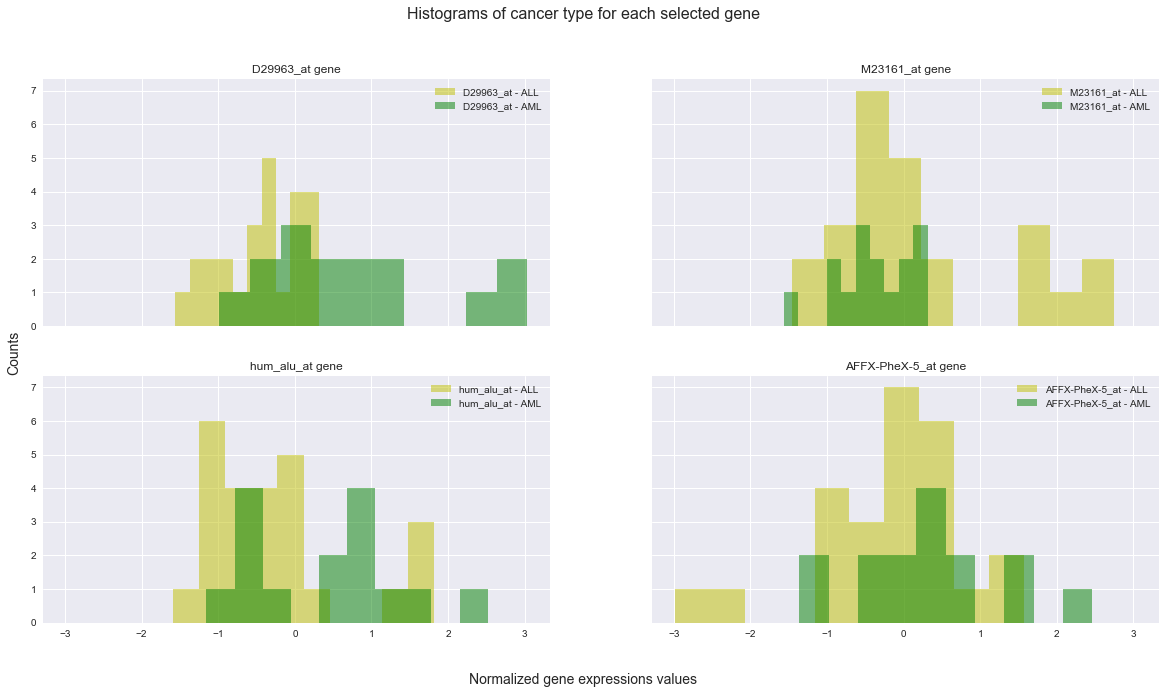

In [144]:
# your code here
fig, ax = plt.subplots(2,2, figsize=(20, 10), sharex=True, sharey=True)

ax[0,0].hist(cancer_ALL['D29963_at'], 10, facecolor='y', alpha=alpha, label="D29963_at - ALL")
ax[0,0].hist(cancer_AML['D29963_at'], 10, facecolor='g', alpha=alpha, label="D29963_at - AML")
ax[0,0].set_title('D29963_at gene')
ax[0,0].legend()

ax[0,1].hist(cancer_ALL['M23161_at'], 10, facecolor='y', alpha=alpha, label="M23161_at - ALL")
ax[0,1].hist(cancer_AML['M23161_at'], 10, facecolor='g', alpha=alpha, label="M23161_at - AML")
ax[0,1].set_title('M23161_at gene')
ax[0,1].legend()

ax[1,0].hist(cancer_ALL['hum_alu_at'], 10, facecolor='y', alpha=alpha, label="hum_alu_at - ALL")
ax[1,0].hist(cancer_AML['hum_alu_at'], 10, facecolor='g', alpha=alpha, label="hum_alu_at - AML")
ax[1,0].set_title('hum_alu_at gene')
ax[1,0].legend()

ax[1,1].hist(cancer_ALL['AFFX-PheX-5_at'], 10, facecolor='y', alpha=alpha, label="AFFX-PheX-5_at - ALL")
ax[1,1].hist(cancer_AML['AFFX-PheX-5_at'], 10, facecolor='g', alpha=alpha, label="AFFX-PheX-5_at - AML")
ax[1,1].set_title('AFFX-PheX-5_at gene')
ax[1,1].legend()

fig.suptitle('Histograms of cancer type for each selected gene', fontsize=16)
fig.text(0.5, 0.04, 'Normalized gene expressions values', ha='center', fontsize=14)
fig.text(0.1, 0.5, 'Counts', va='center', rotation='vertical', fontsize=14)

<HR>
**
The genes don't discriminate between the classes well, but there are definitely portions that can be categorized. For some ranges, there is only one type of class present.<BR>
Eg: Any normalized gene expression value for D29963_at gene greater than 0.25 belongs to AML class.
** 
<HR>

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

Variance explained by each PCA component: [0.15642787 0.11389365]
Total Variance Explained: 0.27032152190271436


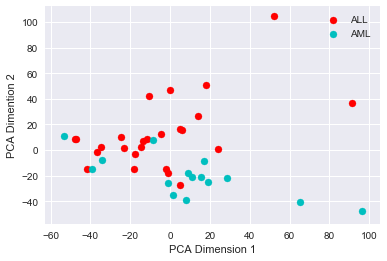

In [146]:
# your code here
pca_transformer = PCA(2).fit(x_train)
x_train_2d = pca_transformer.transform(x_train)

colors = ['r','c']
label_text = ["ALL", "AML"]

for cancer_type in [0,1]:
    cur_df = x_train_2d[y_train==cancer_type]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cancer_type], label=label_text[cancer_type])
    
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

var_explained = pca_transformer.explained_variance_ratio_
print("Variance explained by each PCA component:", var_explained)
print("Total Variance Explained:", np.sum(var_explained))

<HR>
*** The top two principal components don't discriminate between the two classes well at all. The first component explains 15.64% of the variance and the second component explains 11.39%.***
<HR>

## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?


In [153]:
# your code here
from sklearn.linear_model import LinearRegression

linear_fitted_model = LinearRegression().fit(x_train['D29963_at'].values.reshape(-1,1), y_train)
print('R squared on test set: {0:6.4}'.format(linear_fitted_model
                                              .score(x_test['D29963_at'].values.reshape(-1,1), y_test)))

R squared on test set: 0.1795


<HR>
**
Technically, R-Squared is only valid for linear models with numeric data. It is rare to see it reported for models using categorical outcome variables. When your predictor or outcome variables are categorical or counts, the R-Squared will typically be lower than with truly numeric data.
**
<HR>


**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


In [197]:
# your code here
linear_model_train_prediction = linear_fitted_model.predict(x_train['D29963_at'].values.reshape(-1,1)) >= .5
linear_model_test_prediction = linear_fitted_model.predict(x_test['D29963_at'].values.reshape(-1,1)) >= .5

train_accuracy = accuracy_score(y_train, linear_model_train_prediction)
test_accuracy = accuracy_score(y_test, linear_model_test_prediction)

print('Classification Accuracy - Train: {0:4}%'.format(train_accuracy*100))
print('Classification Accuracy - Test: {0:4.4}%'.format(test_accuracy*100))

Classification Accuracy - Train: 80.0%
Classification Accuracy - Test: 75.76%


**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [193]:
# your code here
fitted_lr = LogisticRegression(C=100000).fit(x_train['D29963_at'].values.reshape(-1,1), y_train)
print("Train set score: {0:4.4}%".format(fitted_lr.score(x_train['D29963_at'].values.reshape(-1,1), y_train)*100))
print("Test set score: {0:4.4}%".format(fitted_lr.score(x_test['D29963_at'].values.reshape(-1,1), y_test)*100))

Train set score: 80.0%
Test set score: 75.76%


<HR>
**
The training and test classification accuracies of this model are identical to the linear regreassion model.
**
<HR>

**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

Text(0,0.5,'Probability')

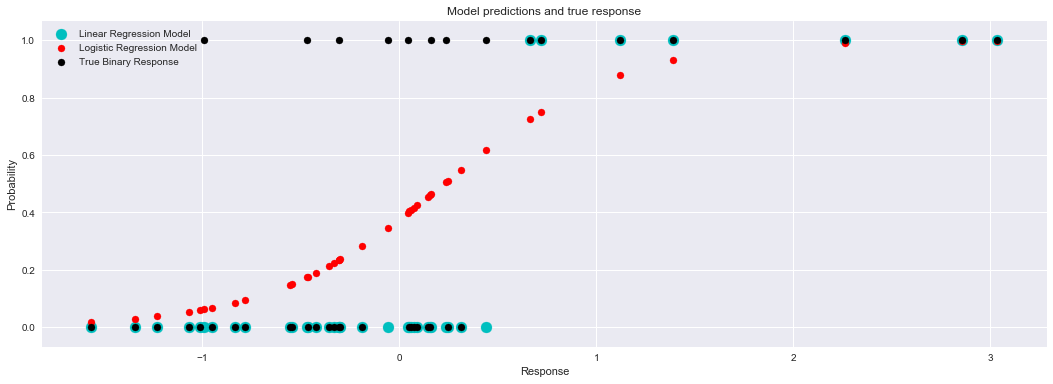

In [236]:
# your code here
logistic_model_train_prediction = fitted_lr.predict_proba(x_train['D29963_at'].values.reshape(-1,1))

fig, ax = plt.subplots(1,1, figsize=(18,6))
plt.scatter(x_train['D29963_at'].values.reshape(-1,1), linear_model_train_prediction, 
            color='c', s=120, label='Linear Regression Model')
plt.scatter(x_train['D29963_at'].values.reshape(-1,1), logistic_model_train_prediction[:,1], 
            label='Logistic Regression Model', color='r')
plt.scatter(x_train['D29963_at'].values.reshape(-1,1), y_train, label='True Binary Response', color='black')
ax.legend()
ax.set_title('Model predictions and true response')
ax.set_xlabel('Response')
ax.set_ylabel('Probability')

<HR>
**
The linear regression model appear better suited for binary classification.
**
<HR>

## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [244]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers 
**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [242]:
# your code here
fitted_multi_lr = LogisticRegression(C=100000).fit(x_train, y_train)

print("Train set score: {0:4.4}%".format(fitted_multi_lr.score(x_train, y_train)*100))
print("Test set score: {0:4.4}%".format(fitted_multi_lr.score(x_test, y_test)*100))

Train set score: 100.0%
Test set score: 90.91%


<HR>**The classification accuracy of this model is far superior to that of the models fitted in question 2 with a single gene (on both the training and test sets)**<HR>

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

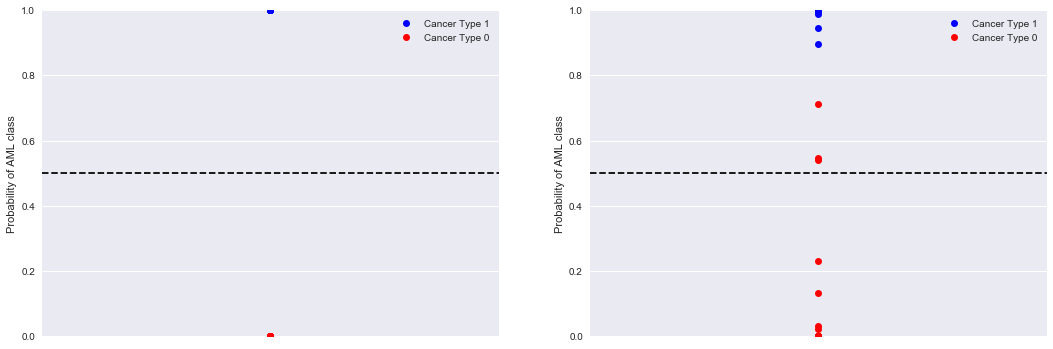

In [255]:
# your code here
multi_logistic_train_prediction = fitted_multi_lr.predict(x_train)
multi_logistic_test_prediction = fitted_multi_lr.predict(x_test)

fig, ax = plt.subplots(1,2, figsize=(18,6))

visualize_prob(fitted_multi_lr, x_train, y_train, ax[0])
visualize_prob(fitted_multi_lr, x_test, y_test, ax[1])

<HR>
** Is there a difference in the spread of probabilities in the training and test plots? **<BR>
Yes there is. The training set shows a perfect 0 and 1 probability separation whereas the test set shows a gradual spread. <BR><HR>
** Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points? ** <BR>
Yes there are in the test set. There are data points just above the 0.5 mark. The points have a probability greater than 50% of being cancer type 1 but are actually cancer type 2. These would classify as false positives for cancer type 1.
<HR>

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

#### Answer:

In [415]:
# your code here
N = 1000
bootstrap_betas = np.zeros([N, len(x_train.columns)])

for cur_bootstrap_rep in range(N):
    
    inds_to_sample = np.random.choice(x_train.index.values, size=x_train.shape[0], replace=True)
    # take the sample
    x_train_resample = x_train.loc[inds_to_sample]
    y_train_resample = y_train[inds_to_sample]

    # fit the model
    bootstrap_model = LogisticRegression(C=100000).fit(x_train_resample, y_train_resample)
    
    # extract the betas and append
    bootstrap_betas[cur_bootstrap_rep] = bootstrap_model.coef_

In [417]:
confidence_intervals = pd.DataFrame()
for feature in x_train.columns:
    index = x_train.columns.get_loc(feature)
    lower_limit, upper_limit = np.percentile(bootstrap_betas[:, index], [5,95])
    confidence_intervals = confidence_intervals.append(pd.DataFrame({'lower_limit': lower_limit, 'upper_limit': upper_limit}, index=[index]))
    
    

In [437]:
results = []
for index, row in confidence_intervals.iterrows(): 
    if row['upper_limit'] > 0 > row['lower_limit']:
        results.append(x_train.columns[index])

print('{0} coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a significance level of 95%'.format(len(x_train.columns)-len(results)))


1837 coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a significance level of 95%


## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

In [21]:
def V_c(d):
    """
    Calculate the volumn of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)  

#### Answers:

In [ ]:
# your code here

----
Your answer here

----

## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

In [ ]:
# your code here

----
Your answer here

----

**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

In [ ]:
# your code here

----
Your answer here

----


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the code provided below.

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
 <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Answers:

**7.0:** First task: split the data using the code provided below. 

In [27]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?


In [1]:
# your code here

----
Your answer here

----

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).


----
Your answer here

----

**7.3:** Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

In [ ]:
# your code here

----
Your answer here

----

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 


In [ ]:
# your code here

**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

----
Your answer here

----

## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [32]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

In [ ]:
# your code here

**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

---
Your answer here

---

**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

---
Your answer here

---